In [30]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax
from utilities import clean_tweet
from tqdm.notebook import tqdm
tqdm.pandas()
import tweetnlp
import matplotlib.pyplot as plt
import glob
import pandas as pd
import torch

def get_pred(model, tweet):
    ouput = model.predict(tweet)
    return ouput['label'] 

#create class to load the model and tokenizer and gives polarity
class SentimentModel:
    def __init__(self):
        self.MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
        self.tokenizer = AutoTokenizer.from_pretrained(self.MODEL)
        self.config = config = AutoConfig.from_pretrained(self.MODEL)
        self.model = AutoModelForSequenceClassification.from_pretrained(self.MODEL)

    def softmax_to_polarity(self, softmax_scores):

        # index of the label with the highest score
        max_index = torch.argmax(softmax_scores)

        if max_index == 0:
            polarity = -1 * softmax_scores[max_index]
        elif max_index == 2:
            polarity = softmax_scores[max_index]
        else:
            polarity = 0
        
        return polarity

    def predict(self, text):
        # get the output from the model
        encoded_input = self.tokenizer(text, return_tensors='pt')
        output = self.model(**encoded_input)
        scores = output[0][0]
        # apply softmax to the scores using tensors
        scores = torch.softmax(scores, dim=0)
        return self.softmax_to_polarity(scores)


In [31]:
model = SentimentModel()
model_sentiment = tweetnlp.load_model('sentiment')

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [67]:
text = "Walking around"
# print polarity
# print(model.predict(text))

def convert_probability_to_polarity(probability):
    # get max index of probability dict

    # get max index of dict
    max_value = max(probability['probability'].values())
    max_key = max(probability['probability'], key=probability['probability'].get)

    # print(max_index, probability)
    if max_key == 'negative':
        polarity = -1 * max_value
    elif max_key == 'positive' :
        polarity = max_value
    else:
        polarity = 0

    return polarity
# print(model_sentiment.predict(text, return_probability=True))
polarity = (convert_probability_to_polarity(model_sentiment.predict(text, return_probability=True)))
print(polarity)

0


In [ ]:

# Read all parquet files from Tweets folder and concatenate them all into one dataframe
df_full = pd.concat([pd.read_parquet(f) for f in glob.glob('Tweets/*.parquet')], ignore_index = True)

In [88]:
# sample 1000 tweets
df = df_full.sample(100000)
df['Tweet_Clean'] = df['Tweet'].progress_apply(lambda x: clean_tweet(x))


  0%|          | 0/100000 [00:00<?, ?it/s]

In [89]:
# prediction form model_sentiment
df['Sentiment_NLP'] = df['Tweet_Clean'].progress_apply(lambda x: get_pred(model_sentiment, x))

  0%|          | 0/100000 [00:00<?, ?it/s]

In [90]:
# prediction form model
df['Sentiment_Polarity'] = df['Tweet_Clean'].progress_apply(lambda x: convert_probability_to_polarity(model_sentiment.predict(x, return_probability=True)))

  0%|          | 0/100000 [00:00<?, ?it/s]

In [91]:
df['Sentiment_Pred'] = df['Sentiment_Polarity'].apply(lambda x: 'positive' if x > 0 else 'negative' if x < 0 else 'neutral')

In [92]:
df[['Sentiment_NLP', 'Sentiment_Pred', 'Sentiment_Polarity']]

,Sentiment_NLP,Sentiment_Pred,Sentiment_Polarity
3810605,negative,negative,-0.898001
3710158,neutral,neutral,0.000000
3325874,negative,negative,-0.851344
244448,positive,positive,0.904088
3136615,negative,negative,-0.940379
...,...,...,...
4359231,positive,positive,0.898739
1133190,negative,negative,-0.871570
1797094,positive,positive,0.786969
562629,negative,negative,-0.764418


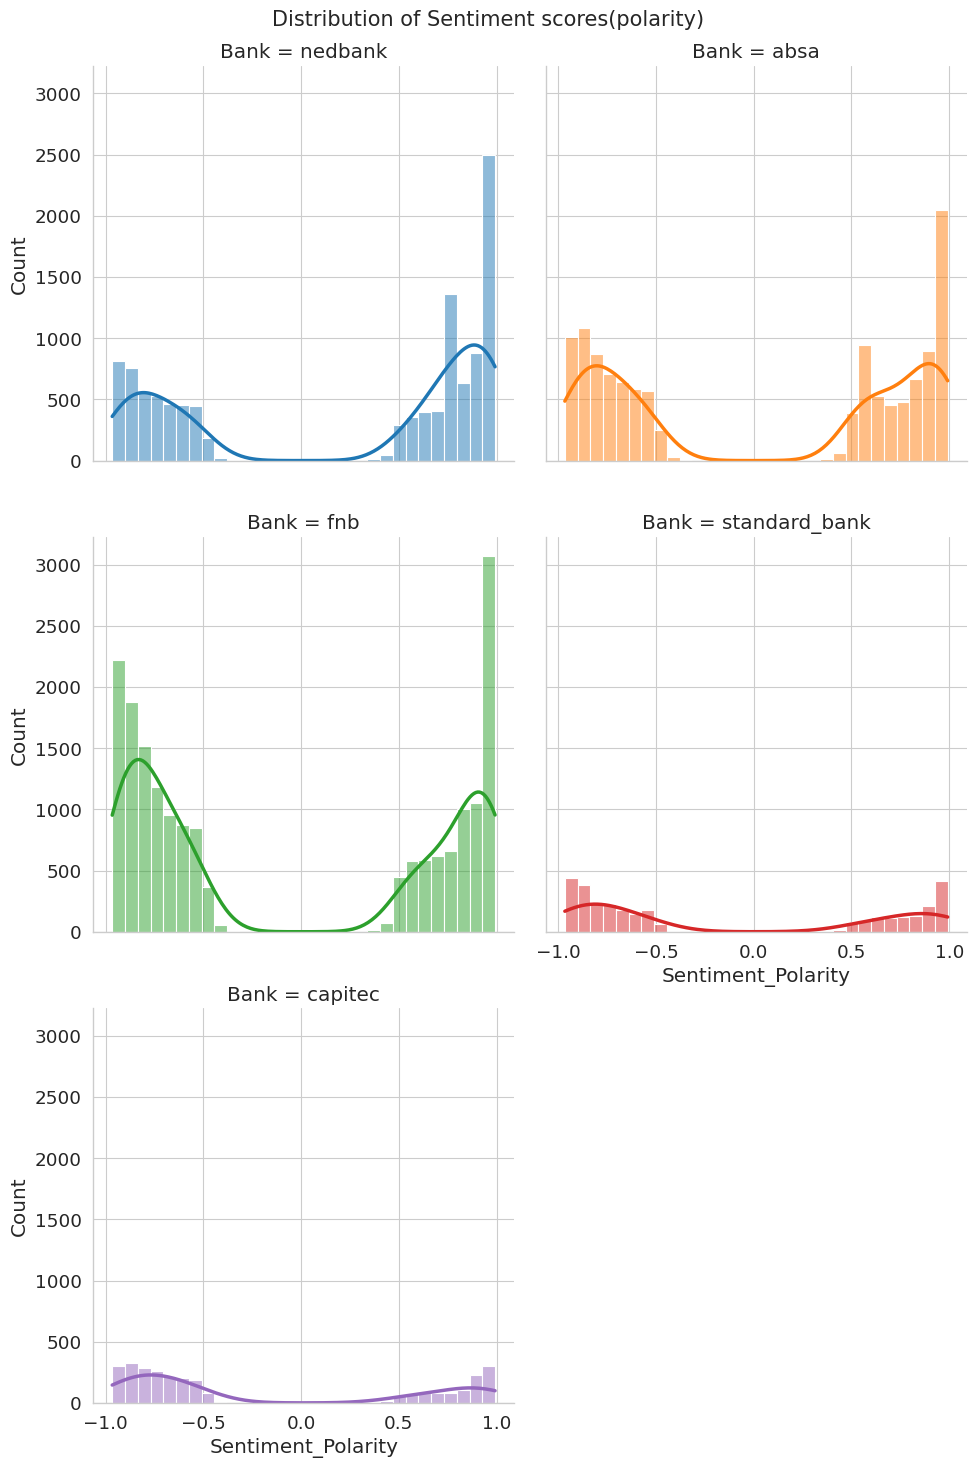

In [93]:
fig1 = sns.displot(data = df[~(df['Sentiment_Polarity']==0)], x="Sentiment_Polarity",
                   col="Bank",
                   col_wrap= 2, 
                   hue="Bank", 
                   legend=False, 
                #    palette= pal,
                   kde = True,
                   bins =30)
fig1.fig.suptitle("Distribution of Sentiment scores(polarity)",fontsize =15 )

plt.tight_layout()
plt.show()

Method to get sentiment wihtout polarity

Get the total count of all sentiment tweets per bank. Subtract the count of neautral tweets. Get a fraction of positive to negative tweets. If the ratio is positive the differece from 50 percent is the percentage of positive sentiment and vice versa